# fit_us_data.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `outputs/us_counties_clean.csv`: The contents of `data/us_counties.csv` after data cleaning by [clean_us_data.ipynb](./clean_us_data.ipynb)
* `outputs/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`

Outputs:
* `outputs/us_counties_curves.csv`: The curves that this notebook generated
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input and output files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [9]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics
from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

In [10]:
# Read in the CSV file and apply the saved type information
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean_meta.json")

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_vertical = (
    pd
    .read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-09-10  Wyoming   Weston        6927         21       0          0   
      2020-09-11  Wyoming   Weston        6927         21       0          0   
      2020-09-12  Wyoming   Weston        6927         23       0          0   
      2020-09-13  Wyoming   Weston        6927         23       0          0   
      2020-09-14  Wyoming   Weston        6927         23       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22              False           False              False  
      2020-01-23              False           False              False  
      2020-01-24              False           False              False  
      2020-01-25              False           False              False  
      2020-01-26              False           False              False  
...                             ...             ...                ...  
56045 2020-09-10              False           False              False  
      2020-09-11              False           False              False  
      2020-09-12              False           False              False  
      2020-09-13              False           False              False  
      2020-09-14              False           False              False  

[744654 rows x 9 columns]

In [11]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
for col in ["Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"]:
    cases_vertical[col] = cases_vertical[col].astype(np.int8)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-09-10  Wyoming   Weston        6927         21       0          0   
      2020-09-11  Wyoming   Weston        6927         21       0          0   
      2020-09-12  Wyoming   Weston        6927         23       0          0   
      2020-09-13  Wyoming   Weston        6927         23       0          0   
      2020-09-14  Wyoming   Weston        6927         23       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22                  0               0                  0  
      2020-01-23                  0               0                  0  
      2020-01-24                  0               0                  0  
      2020-01-25                  0               0                  0  
      2020-01-26                  0               0                  0  
...                             ...             ...                ...  
56045 2020-09-10                  0               0                  0  
      2020-09-11                  0               0                  0  
      2020-09-12                  0               0                  0  
      2020-09-13                  0               0                  0  
      2020-09-14                  0               0                  0  

[744654 rows x 9 columns]

In [12]:
# Use Text Extensions for Pandas to collapse each time series or mask down to a single cell
cases, dates = util.collapse_time_series(cases_vertical, [
    "Confirmed", "Deaths", "Recovered", 
    "Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"])
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 ...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [13]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

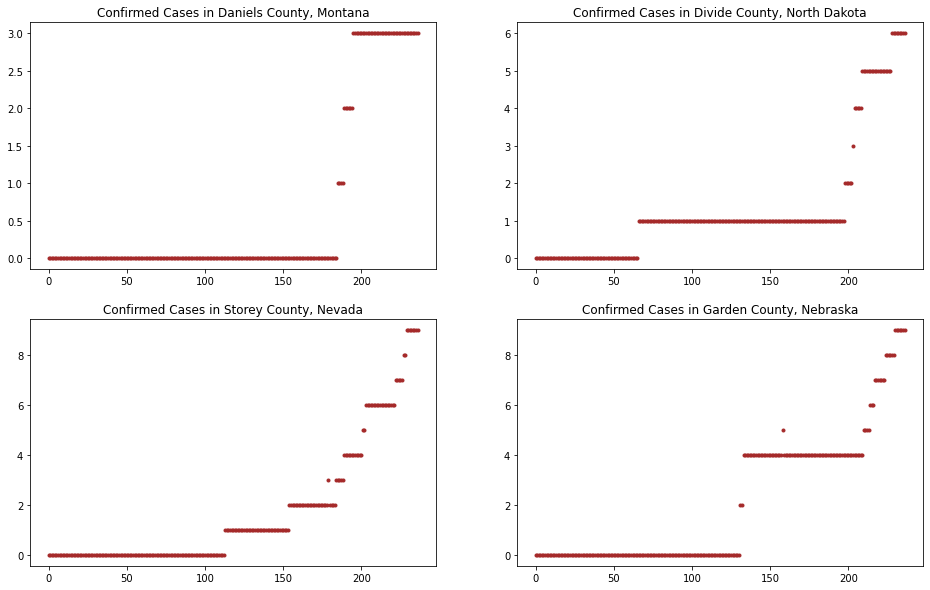

In [14]:
# Because these time series are integer-valued, there can be
# problems with aliasing. 
# Here are some examples of what aliasing looks like:
# (graph_examples() function defined in util.py)
util.graph_examples(cases, ts_col_name, {}, 
                    mask=(np.max(cases[ts_col_name].array, axis=1) < 10))

In [15]:
# To avoid problems due to aliasing, we will restrict the analysis
# in the rest of this notebook to time series whose maximum values
# go above a threshold:
alias_threshold = 100

# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].array, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].array, axis=1) >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].array[:,first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].array[:,first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorType):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)
        
filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier
FIPS,,,,,
1001,Alabama,Autauga,55869,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
1003,Alabama,Baldwin,223234,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
1005,Alabama,Barbour,24686,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
1007,Alabama,Bibb,22394,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
1009,Alabama,Blount,57826,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,[ 0. 0. 1. 1. 1. 1. 1. 2. 4. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
56037,Wyoming,Sweetwater,42343,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
56039,Wyoming,Teton,23464,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...


In [17]:
# Warm-up: Fit a straight line.
# We use sklearn's implementation of BGFS as the optimizer.

# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].array.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)

def linear_curve(m, b):
    return m * x + b

def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)

linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))

linear = filtered[metadata_cols].copy()
linear["Result_Object"] = [
    scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(ts), bounds=linear_bounds)
    for ts in series_values
]
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 4522837.619474476, 'jac': [0.0, 12073....",7.725860,-189.000000,[-189. -181.27413987 -173.54827973 -165...,0.903106
1003,Alabama,Baldwin,223234,"{'fun': 151563067.5977291, 'jac': [-2.98023199...",19.179853,-189.000000,[-1.89000000e+02 -1.69820147e+02 -1.50640293e+0...,0.705698
1005,Alabama,Barbour,24686,"{'fun': 558514.6834287094, 'jac': [-1.62981451...",4.266095,-130.224662,[-130.224662 -125.95856681 -121.69247162 -117...,0.948273
1007,Alabama,Bibb,22394,"{'fun': 833755.5519654795, 'jac': [1.187436289...",3.301837,-121.832874,[-1.21832874e+02 -1.18531037e+02 -1.15229200e+0...,0.880331
1009,Alabama,Blount,57826,"{'fun': 5361054.648847485, 'jac': [0.0, 7622.3...",5.614781,-189.000000,[-189. -183.38521872 -177.77043743 -172...,0.801760
...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,"{'fun': 164457.07901686017, 'jac': [-0.7072230...",0.747677,-27.345148,[-27.34514837 -26.59747121 -25.84979405 -25.102...,0.656635
56037,Wyoming,Sweetwater,42343,"{'fun': 348272.8195975153, 'jac': [0.0, -0.005...",1.958560,-76.030556,[-76.0305557 -74.07199591 -72.11343612 -70.154...,0.861043
56039,Wyoming,Teton,23464,"{'fun': 545436.0802543076, 'jac': [-0.26775524...",2.479125,-58.312874,[-58.31287394 -55.83374859 -53.35462325 -50.875...,0.863748


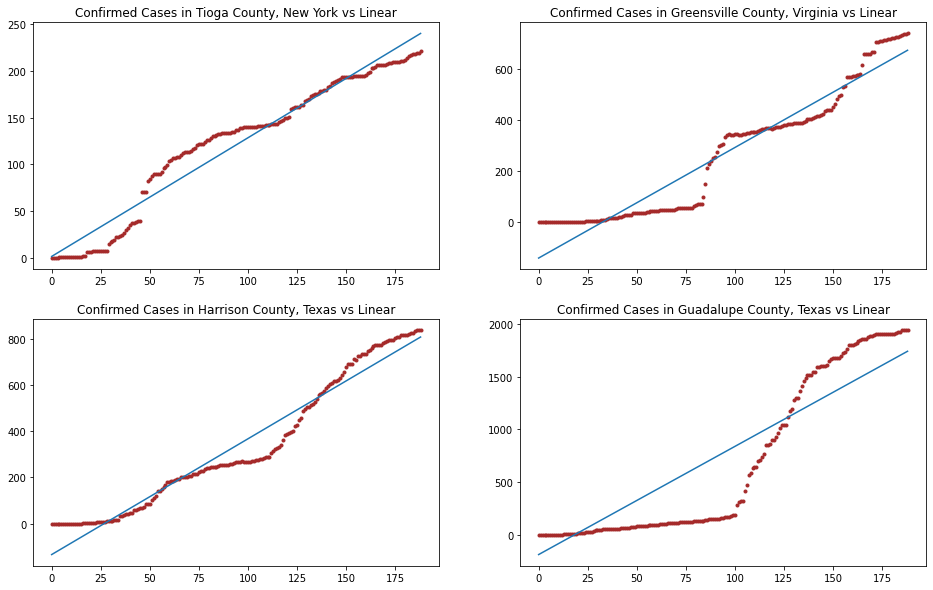

In [18]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

In [22]:
# Now let's fit some more appropriate curves to this data.
# First, break out the repetitive parts of the curve-fitting process into
# a Python function.
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,     
                 regularize_fn = None):
    """
    Fit a curve to a column full of time series.
    
    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.
    
    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.
    
    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].array.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = [
        scipy.optimize.minimize(
            objective, initial_guess,
            args=(ts), bounds=bounds)
        for ts in series_values
    ]
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [23]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate * (X - offset))
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.001, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))
    
    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curves to each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)
    
    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        
        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))
        
        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)
    
    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])
    
    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


In [24]:
# Now we can fit those curves.
# First, the exponential curves.
exp_df = fit_exponential(ts_col_name)
exp_df

,State,County,Population,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 23399420.328967668, 'jac': [1.86264514...",0.041146,0.0,[1.00000000e+00 1.04200455e+00 1.08577347e+00 1...,0.498710
1003,Alabama,Baldwin,223234,"{'fun': 191095105.82347628, 'jac': [438.094139...",0.047533,0.0,[1.00000000e+00 1.04868053e+00 1.09973085e+00 1...,0.628936
1005,Alabama,Barbour,24686,"{'fun': 7304963.551622689, 'jac': [-56.6244125...",0.037057,0.0,[1.00000000e+00 1.03775183e+00 1.07692885e+00 1...,0.323452
1007,Alabama,Bibb,22394,"{'fun': 2013961.9859925436, 'jac': [-0.0465661...",0.036012,0.0,[ 1. 1.03666856 1.0746817 1.114...,0.710936
1009,Alabama,Blount,57826,"{'fun': 6600184.584176554, 'jac': [-53.6441802...",0.039524,0.0,[1.00000000e+00 1.04031508e+00 1.08225546e+00 1...,0.755940
...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,"{'fun': 8722.66931221765, 'jac': [0.0001818989...",0.028515,0.0,[ 1. 1.02892541 1.0586875 1.089...,0.981788
56037,Wyoming,Sweetwater,42343,"{'fun': 693031.4254044503, 'jac': [0.023283064...",0.032939,0.0,[ 1. 1.03348747 1.06809635 1.103...,0.723489
56039,Wyoming,Teton,23464,"{'fun': 1798562.2246039438, 'jac': [0.04656612...",0.034899,0.0,[ 1. 1.03551486 1.07229102 1.110...,0.550714


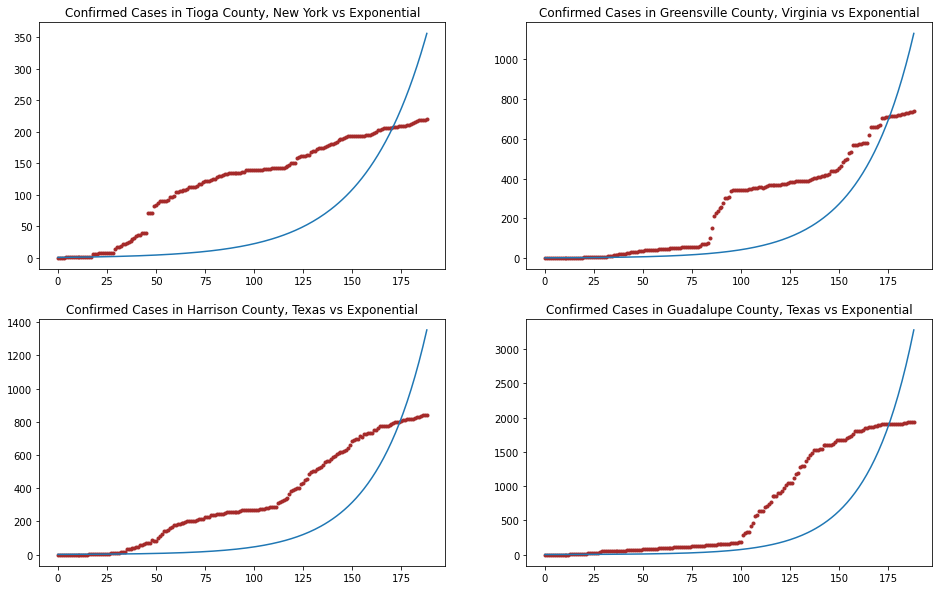

In [25]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

In [26]:
# Then fit the logistic function
log_df = fit_logistic(ts_col_name)
log_df

,State,County,Population,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 44466.32409984598, 'jac': [-0.00363801...",1551.442009,0.040463,128.448136,[ 8.53408138 8.88445653 9.24913044 9...,0.999047
1003,Alabama,Baldwin,223234,"{'fun': 2634713.000227625, 'jac': [-0.18626648...",4805.747396,0.066776,136.974252,[5.12166835e-01 5.47530883e-01 5.85336448e-01 6...,0.994884
1005,Alabama,Barbour,24686,"{'fun': 28721.690941171633, 'jac': [0.00291038...",661.211562,0.044781,111.208761,[ 4.51403645 4.71929803 4.93382312 5.158...,0.997340
1007,Alabama,Bibb,22394,"{'fun': 19844.255219314222, 'jac': [-0.0003637...",705.162280,0.037003,142.758050,[ 3.56403145 3.69767697 3.83630658 3.980...,0.997152
1009,Alabama,Blount,57826,"{'fun': 63333.94247973858, 'jac': [-0.00072760...",1188.998104,0.054513,139.972227,[5.77010174e-01 6.09321168e-01 6.43440509e-01 6...,0.997658
...,...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,"{'fun': 14044.484084751326, 'jac': [-0.0001818...",407.008575,0.038368,189.000000,[ 0.28838003 0.29965137 0.31136292 0.323...,0.970677
56037,Wyoming,Sweetwater,42343,"{'fun': 10225.874448031329, 'jac': [-0.0003637...",327.183756,0.056815,128.069279,[2.26188977e-01 2.39402227e-01 2.53386756e-01 2...,0.995920
56039,Wyoming,Teton,23464,"{'fun': 180057.28626893705, 'jac': [0.00582076...",924.773038,0.021839,179.819925,[ 17.86655526 18.25325067 18.64814343 19.051...,0.955021


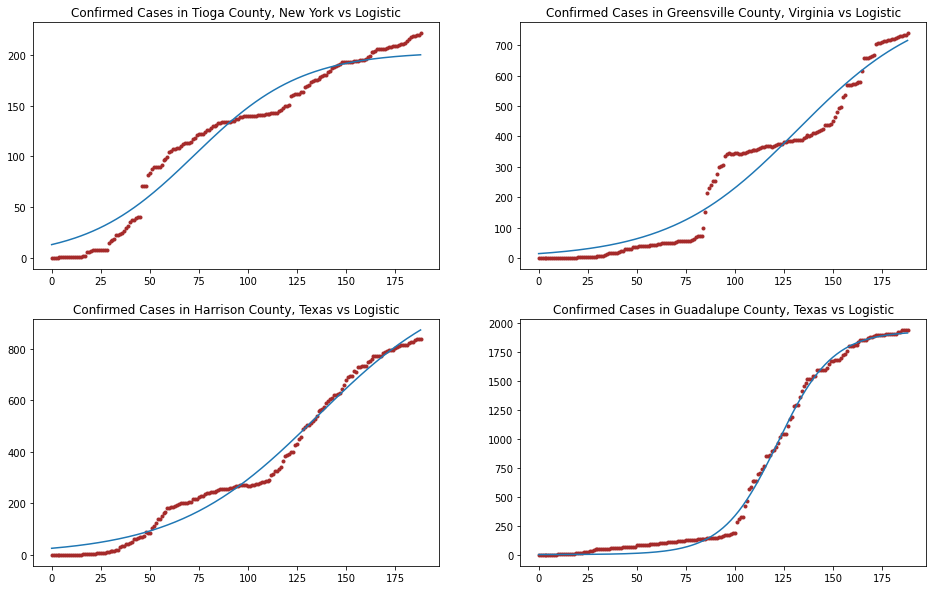

In [27]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

In [28]:
# And finally a mixture of two copies of the logistic function
log2_df = fit_logistic2(ts_col_name)
log2_df

/Users/freiss/pd/cn-demo2/env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp
/Users/freiss/pd/cn-demo2/env/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp


,State,County,Population,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,"{'fun': 21538.23042951901, 'jac': [-0.02364684...",631.835383,0.065720,86.908916,1817.741674,0.055128,127.978962,112.291176,189.000000,[ 1.99185554 2.12254647 2.26172759 2...,0.999539
1003,Alabama,Baldwin,223234,"{'fun': 735452.6768236177, 'jac': [2.363229158...",613.499923,0.120170,43.042599,5622.538773,0.083727,134.758887,0.005097,128.102560,[1.80477189e+00 2.02493591e+00 2.27175186e+00 2...,0.998572
1005,Alabama,Barbour,24686,"{'fun': 24616.91860775262, 'jac': [0.0, -0.0, ...",576.932344,10.000000,188.999996,666.042293,0.043512,111.520015,29.052494,36.468221,[4.52969921e-02 5.40543846e-02 6.44922237e-02 7...,0.997720
1007,Alabama,Bibb,22394,"{'fun': 19772.15196051432, 'jac': [-0.19208512...",676.448138,0.041137,142.909394,706.808941,0.036872,142.909261,10.000043,19.999971,[ 2.17841211 2.29271013 2.41401757 2.542...,0.997162
1009,Alabama,Blount,57826,"{'fun': 63363.632907441344, 'jac': [0.0, 0.0, ...",1127.876538,1.489049,139.973469,1188.996699,0.054513,139.972171,13.571153,14.727614,[2.57914795e-08 6.46660710e-08 1.62134709e-07 4...,0.997657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,"{'fun': 2411.8576560869487, 'jac': [-4.5827582...",205.265306,0.012749,188.997864,469.996844,0.046789,189.000000,0.000000,99.296046,[ 8.75049934 8.81169662 8.87305812 8.934...,0.994964
56037,Wyoming,Sweetwater,42343,"{'fun': 10224.261528938292, 'jac': [0.0, -0.0,...",305.648987,10.000000,189.000000,327.191073,0.056810,128.070268,7.364973,8.073996,[3.55116257e-07 1.02168888e-06 2.93943419e-06 8...,0.995921
56039,Wyoming,Teton,23464,"{'fun': 171333.44181155, 'jac': [0.0, -0.18044...",1018.725141,0.036166,188.876402,1021.185444,0.020647,189.000000,13.663303,15.385170,[ 1.09917653 1.1397762 1.18200317 1.226...,0.957200


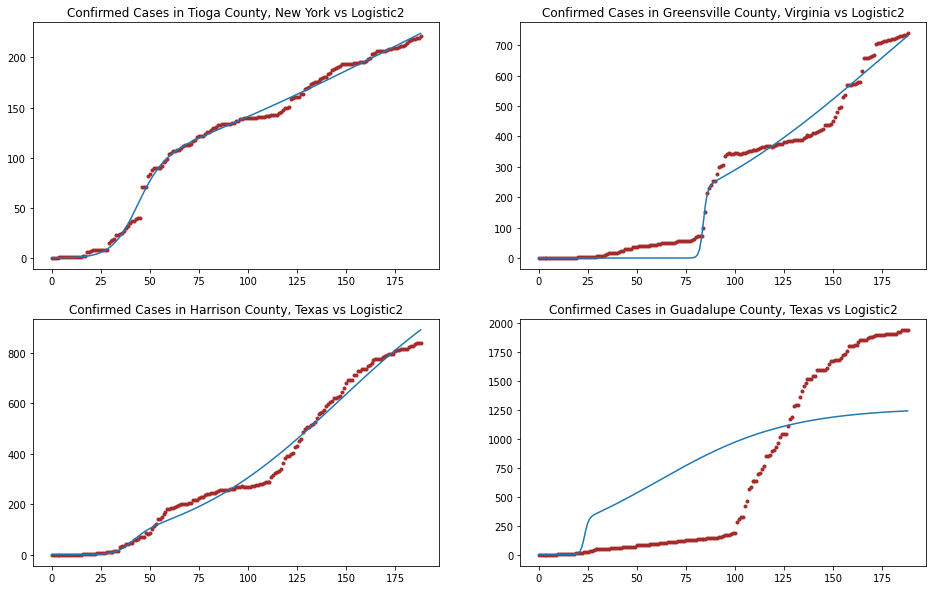

In [29]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

In [30]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[1.00000000e+00 1.04200455e+00 1.08577347e+00 1...,[ 8.53408138 8.88445653 9.24913044 9...,[ 1.99185554 2.12254647 2.26172759 2...
1003,Alabama,Baldwin,223234,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[1.00000000e+00 1.04868053e+00 1.09973085e+00 1...,[5.12166835e-01 5.47530883e-01 5.85336448e-01 6...,[1.80477189e+00 2.02493591e+00 2.27175186e+00 2...
1005,Alabama,Barbour,24686,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[1.00000000e+00 1.03775183e+00 1.07692885e+00 1...,[ 4.51403645 4.71929803 4.93382312 5.158...,[4.52969921e-02 5.40543846e-02 6.44922237e-02 7...
1007,Alabama,Bibb,22394,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[ 1. 1.03666856 1.0746817 1.114...,[ 3.56403145 3.69767697 3.83630658 3.980...,[ 2.17841211 2.29271013 2.41401757 2.542...
1009,Alabama,Blount,57826,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[1.00000000e+00 1.04031508e+00 1.08225546e+00 1...,[5.77010174e-01 6.09321168e-01 6.43440509e-01 6...,[2.57914795e-08 6.46660710e-08 1.62134709e-07 4...
...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,[ 0. 0. 1. 1. 1. 1. 1. 2. 4. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[ 1. 1.02892541 1.0586875 1.089...,[ 0.28838003 0.29965137 0.31136292 0.323...,[ 8.75049934 8.81169662 8.87305812 8.934...
56037,Wyoming,Sweetwater,42343,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[ 1. 1.03348747 1.06809635 1.103...,[2.26188977e-01 2.39402227e-01 2.53386756e-01 2...,[3.55116257e-07 1.02168888e-06 2.93943419e-06 8...
56039,Wyoming,Teton,23464,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...,[ 1. 1.03551486 1.07229102 1.110...,[ 17.86655526 18.25325067 18.64814343 19.051...,[ 1.09917653 1.1397762 1.18200317 1.226...


In [31]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

State    County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                      
1001  2020-03-10  Alabama   Autauga       55869        0.0              False   
      2020-03-11  Alabama   Autauga       55869        0.0              False   
      2020-03-12  Alabama   Autauga       55869        0.0              False   
      2020-03-13  Alabama   Autauga       55869        0.0              False   
      2020-03-14  Alabama   Autauga       55869        0.0              False   
...                   ...       ...         ...        ...                ...   
56043 2020-09-10  Wyoming  Washakie        7805      111.0              False   
      2020-09-11  Wyoming  Washakie        7805      111.0              False   
      2020-09-12  Wyoming  Washakie        7805      111.0              False   
      2020-09-13  Wyoming  Washakie        7805      111.0              False   
      2020-09-14  Wyoming  Washakie        7805      111.0              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1001  2020-03-10     1.000000    8.534081    1.991856  
      2020-03-11     1.042005    8.884457    2.122546  
      2020-03-12     1.085773    9.249130    2.261728  
      2020-03-13     1.131381    9.628679    2.409942  
      2020-03-14     1.178904   10.023702    2.567768  
...                       ...         ...         ...  
56043 2020-09-10   140.526425  117.290527  116.319431  
      2020-09-11   144.354589  118.657346  117.650524  
      2020-09-12   148.287039  120.025234  118.982870  
      2020-09-13   152.326615  121.393855  120.316157  
      2020-09-14   156.476235  122.762868  121.650072  

[449820 rows x 8 columns]

In [32]:
# Write out the results to a CSV file plus a JSON file of type metadata.
counties_curves_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
curves_vertical.to_csv(counties_curves_csv_data_file, index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}

counties_curves_json_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")
print(f"Writing curves to {counties_curves_json_data_file}")
with open(counties_curves_json_data_file, "w") as f:
    json.dump(col_type_mapping, f)

Writing curves to outputs/us_counties_curves_meta.json


In [33]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,0.041146,0.0,1551.442009,0.040463,128.448136,631.835383,0.065720,86.908916,1817.741674,0.055128,127.978962,112.291176,189.000000
1003,Alabama,Baldwin,223234,0.047533,0.0,4805.747396,0.066776,136.974252,613.499923,0.120170,43.042599,5622.538773,0.083727,134.758887,0.005097,128.102560
1005,Alabama,Barbour,24686,0.037057,0.0,661.211562,0.044781,111.208761,576.932344,10.000000,188.999996,666.042293,0.043512,111.520015,29.052494,36.468221
1007,Alabama,Bibb,22394,0.036012,0.0,705.162280,0.037003,142.758050,676.448138,0.041137,142.909394,706.808941,0.036872,142.909261,10.000043,19.999971
1009,Alabama,Blount,57826,0.039524,0.0,1188.998104,0.054513,139.972227,1127.876538,1.489049,139.973469,1188.996699,0.054513,139.972171,13.571153,14.727614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,0.028515,0.0,407.008575,0.038368,189.000000,205.265306,0.012749,188.997864,469.996844,0.046789,189.000000,0.000000,99.296046
56037,Wyoming,Sweetwater,42343,0.032939,0.0,327.183756,0.056815,128.069279,305.648987,10.000000,189.000000,327.191073,0.056810,128.070268,7.364973,8.073996
56039,Wyoming,Teton,23464,0.034899,0.0,924.773038,0.021839,179.819925,1018.725141,0.036166,188.876402,1021.185444,0.020647,189.000000,13.663303,15.385170


In [34]:
counties_curves_params_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
print(f"Writing parameters of curves to {counties_curves_params_csv_data_file}.")
params.to_csv(counties_curves_params_csv_data_file, index=True)

Writing parameters of curves to outputs/us_counties_curves_params.csv.
